In [1]:
import tensorflow as tf
import keras
from keras import models
import numpy as np
from keract import get_activations
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import SBX
from pymoo.core.problem import Problem, ElementwiseProblem
import random as rng
import pandas as pd
import matplotlib.pyplot as pyplot

In [2]:
# Preparing the mnist dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

x_train = np.repeat(x_train, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = tf.image.resize(x_train, [32, 32]) # if we want to resize 
x_test = tf.image.resize(x_test, [32, 32])

y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [3]:
# Building the model
input = tf.keras.Input(shape=(32, 32, 3))

resnet = tf.keras.applications.ResNet50(weights='imagenet',include_top = False, input_tensor = input)

gap = tf.keras.layers.GlobalMaxPooling2D()(resnet.output)

output = tf.keras.layers.Dense(10, activation='softmax', use_bias=True)(gap)

func_model = tf.keras.Model(resnet.input, output)

In [7]:
# Training the model
func_model.compile(
          loss  = keras.losses.CategoricalCrossentropy(),
          metrics = keras.metrics.CategoricalAccuracy(),
          optimizer = keras.optimizers.Adam())

func_model.fit(x_train, y_train, batch_size=128, epochs=10, verbose = 2)

Epoch 1/10
469/469 - 792s - loss: 0.1173 - categorical_accuracy: 0.9684 - 792s/epoch - 2s/step
Epoch 2/10
469/469 - 753s - loss: 0.0454 - categorical_accuracy: 0.9882 - 753s/epoch - 2s/step
Epoch 3/10
469/469 - 761s - loss: 0.0367 - categorical_accuracy: 0.9903 - 761s/epoch - 2s/step
Epoch 4/10
469/469 - 778s - loss: 0.1400 - categorical_accuracy: 0.9738 - 778s/epoch - 2s/step
Epoch 5/10
469/469 - 780s - loss: 0.0394 - categorical_accuracy: 0.9890 - 780s/epoch - 2s/step
Epoch 6/10
469/469 - 785s - loss: 0.0266 - categorical_accuracy: 0.9919 - 785s/epoch - 2s/step
Epoch 7/10
469/469 - 778s - loss: 0.0219 - categorical_accuracy: 0.9937 - 778s/epoch - 2s/step
Epoch 8/10
469/469 - 800s - loss: 0.0221 - categorical_accuracy: 0.9932 - 800s/epoch - 2s/step
Epoch 9/10
469/469 - 785s - loss: 0.0207 - categorical_accuracy: 0.9941 - 785s/epoch - 2s/step
Epoch 10/10
469/469 - 780s - loss: 0.0181 - categorical_accuracy: 0.9949 - 780s/epoch - 2s/step


In [4]:
# Save the model
# func_model.save('resnet50_mnist')

# Load model from save
model = keras.models.load_model('resnet50_mnist')

In [5]:
# Nac implementation
def Neuron_Activation_Coverage(model, input_img):
    
    if len(input_img.shape) < 4:
        input_img = np.expand_dims(input_img, axis=0)

    activations = get_activations(model, input_img, auto_compile=True)
    del activations["input_1"]

    total_nodes = 0
    non_zeros = 0
    for value in activations.values():
        total_nodes += value.size
        non_zeros += np.count_nonzero(value)

    return non_zeros / total_nodes

nac = Neuron_Activation_Coverage(model, x_test[0])

print("NAC: ", nac)

NAC:  0.8549664142150488


In [36]:
# Problem class for NSGA
class NCMax(ElementwiseProblem):
    def __init__(self, input_img):
        super().__init__(
            n_var=784, n_obj=1, n_constr=0, xl=0.0, xu=1.0)
        self.input_img = input_img
    
    def _evaluate(self, x, out, *args, **kwargs):
        x = np.reshape(x, (28, 28, 1))
        x = np.repeat(x, 3, axis=-1)
        x = tf.image.resize(x, [32, 32])
        perturbed_img = self.input_img + x
        nc = Neuron_Activation_Coverage(model, perturbed_img)
        ret_val = 1.0 / nc
        out["F"] = ret_val

alg = NSGA2(pop_size = 30, offsprings=30,
            sampling=FloatRandomSampling(),
            crossovers=SBX(),
            mutation=PolynomialMutation(),)

challenging_images = np.zeros(shape=(10000, 32, 32, 3))

random_indexes = rng.sample(range(0, 10000), 100)

# Applying NSGA to images / a random image
for i in range(0, 1):
    problem = NCMax(x_test[random_indexes[i]])
    
    res = minimize(problem, alg, ("n_gen", 500))
    if res.X.size > 784:                                    # Sometimes the result object contains more than one element, if that's the case we simply pick one of them.
        noise = np.reshape(res.X[0], (28, 28, 1))
        noise = np.repeat(noise, 3, axis=-1)
        noise = tf.image.resize(noise, [32, 32])
    else:
        noise = np.reshape(res.X, (28, 28, 1))
        noise = np.repeat(noise, 3, axis=-1)
        noise = tf.image.resize(noise, [32, 32])

    challenging_img = x_test[random_indexes[i]] + noise
    challenging_images[i] = challenging_img

In [37]:
x_test_nacs = []
challenging_images_nacs = []
absolute_increase = []
relative_increase = []

# Calculates NAC for image(s) pre and post nsga
for i in range(0, 1):
    pre_NSGA = Neuron_Activation_Coverage(model, x_test[random_indexes[i]])
    post_NSGA = Neuron_Activation_Coverage(model, challenging_images[i])
    x_test_nacs.append(pre_NSGA)
    challenging_images_nacs.append(post_NSGA)
    absolute_increase.append(post_NSGA - pre_NSGA)
    relative_increase.append((post_NSGA - pre_NSGA) / pre_NSGA)

# Converts data to a more readable format
dataset = {
    "Normal Images": x_test_nacs,
    "Challenging Images": challenging_images_nacs,
    "Absolute Increase": absolute_increase,
    "Relative Increase": relative_increase
}

table = pd.DataFrame(dataset)

print(table)

# table.index += 1

# table.to_excel("temp.xlsx")

   Normal Images  Challenging Images  Absolute Increase  Relative Increase
0        0.85186            0.854769           0.002909           0.003415


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


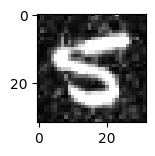

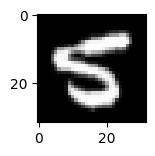

In [38]:
# Post NSGA image
pyplot.subplot(330 + 1)
pyplot.imshow(challenging_images[0], cmap=pyplot.get_cmap('gray'))
pyplot.show()

# Pre NSGA image
pyplot.subplot(330 + 1)
pyplot.imshow(x_test[random_indexes[0]], cmap=pyplot.get_cmap('gray'))
pyplot.show()